# Correct viral barcodes in progeny
This Python Jupyter notebook corrects viral barcodes in the progeny. Viral barcodes are input as read count data.

The notebook uses `UMI tools` to correct the viral barcodes. UMI tools outputs a set of corrected viral barcodes for each progeny sample. The notebook then associates each original viral barcode with its corrected viral barcodes and aggregates the counts for the corrected viral barcodes. Finally, the notebook outputs the corrected viral barcode count.

**Notes about UMI_tools**
* Using directional adjacency method. This has [been demonstrated on simulated data](https://cgatoxford.wordpress.com/2015/08/14/unique-molecular-identifiers-the-problem-the-solution-and-the-proof/) to produce a more accurate estimate of true UMI number than other heuristics.
* Sequence must be input as byte. See definition here: https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal
* The corrected barcode is returned as the first barcode in the group list. See umi_tools API documentation: https://umi-tools.readthedocs.io/en/latest/API.html

## Notebook setup

Import Python modules:

In [1]:
import gzip

from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy as np

import pandas as pd

import plotnine as p9

from umi_tools import UMIClusterer

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_bc_in_progeny_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny.csv.gz'
viral_bc_in_progeny_corrected_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_corrected.csv.gz'
plot = 'scPP_progeny_corrected.pdf'
expt = 'scProgenyProduction_trial3'

Set plot style

In [3]:
p9.theme_set(p9.theme_classic())

Import barcode frequency data

In [4]:
viral_bc_df = pd.read_csv(gzip.open(viral_bc_in_progeny_csv))
display(viral_bc_df)

,source,tag,gene,replicate,barcode,count
0,supernatant,syn,fluHA,replicate_1,ATTGTAGTTCAGAGTG,27744
1,supernatant,syn,fluHA,replicate_1,TTAGAAACGCATTAAG,13986
2,supernatant,syn,fluHA,replicate_1,AAATTGTGGTCAGATC,12368
3,supernatant,syn,fluHA,replicate_1,ATAGAATCGTAGGTAT,12347
4,supernatant,syn,fluHA,replicate_1,TTGTCTAGCAGAGAAA,10349
...,...,...,...,...,...,...
68824,supernatant,wt,fluNA,replicate_2,TTTTGCTTCGAGATAT,1
68825,supernatant,wt,fluNA,replicate_2,TTTTGCTTCGAGGTAG,1
68826,supernatant,wt,fluNA,replicate_2,TTTTGCTTCGTGATAG,1
68827,supernatant,wt,fluNA,replicate_2,TTTTGCTTCTAGATAG,1


## Data processing

Cluster barcodes within each cell

In [5]:
clusterer = UMIClusterer(cluster_method="directional")

lookup_list = []

for (source, tag, gene, replicate), df in (viral_bc_df
                                           .groupby(['source',
                                                     'tag',
                                                     'gene',
                                                     'replicate'])):
    # Convert dataframe to dictionary. Dict requried input for umi_tools.
    viral_bc_dict = df.set_index('barcode')['count'].to_dict()

    # Convert barcode strings to byte. Byte required dtype for umi_tools.
    byte_dict = {}
    for key, value in viral_bc_dict.items():
        byte_dict[key.encode("utf-8")] = float(value)

    # Cluster barcodes
    bc_groups = clusterer(byte_dict, threshold=1)
    groups_df = pd.DataFrame(bc_groups)
    groups_df = (groups_df
                 .stack()
                 .str
                 .decode('utf-8')
                 .unstack())  # Convert bytes back to string
    groups_df = groups_df.rename(columns={0: 'corrected_viral_bc'})
    groups_df = groups_df.set_index('corrected_viral_bc', drop=False)

    # Generate lookup table for this sample
    temp_lookup_df = (groups_df.melt(ignore_index=False,
                                     value_name='original_viral_bc')
                      ['original_viral_bc']
                      .dropna()
                      .reset_index())
    temp_lookup_df['source'] = source
    temp_lookup_df['tag'] = tag
    temp_lookup_df['gene'] = gene
    temp_lookup_df['replicate'] = replicate
    lookup_list.append(temp_lookup_df)

lookup_df = pd.concat(lookup_list)
display(lookup_df)

,corrected_viral_bc,original_viral_bc,source,tag,gene,replicate
0,ATTGTAGTTCAGAGTG,ATTGTAGTTCAGAGTG,supernatant,syn,fluHA,replicate_1
1,TTAGAAACGCATTAAG,TTAGAAACGCATTAAG,supernatant,syn,fluHA,replicate_1
2,AAATTGTGGTCAGATC,AAATTGTGGTCAGATC,supernatant,syn,fluHA,replicate_1
3,ATAGAATCGTAGGTAT,ATAGAATCGTAGGTAT,supernatant,syn,fluHA,replicate_1
4,TTGTCTAGCAGAGAAA,TTGTCTAGCAGAGAAA,supernatant,syn,fluHA,replicate_1
...,...,...,...,...,...,...
5311,TTGTGAGCGAAGTGCG,TTTTGAGCGAAGTGCG,supernatant,wt,fluNA,replicate_2
5312,CACCCCGTTAGTGGGG,CACTCCGTTAGTGGGG,supernatant,wt,fluNA,replicate_2
5313,CACCCCGTTAGTGGGG,CACCTCGTTAGTGGGG,supernatant,wt,fluNA,replicate_2
5314,CACCCCGTTAGTGGGG,CACCCCGTTAGTGAGG,supernatant,wt,fluNA,replicate_2


Merge corrected barcode data with barcode frequency data.

In [6]:
viral_bc_df = pd.merge(viral_bc_df,
                       lookup_df,
                       how='outer',
                       left_on=['source', 'tag', 'gene', 'replicate', 'barcode'],
                       right_on=['source', 'tag', 'gene', 'replicate', 'original_viral_bc'],
                       validate='one_to_one')
assert viral_bc_df.isnull().sum().sum() == 0, \
       "Mismatch between barcode frequencies and " \
       "corrected barcodes dataframes"

viral_bc_df = viral_bc_df.drop('barcode', axis=1)

Aggregate counts on corrected barcodes.

In [7]:
viral_bc_df = pd.merge(viral_bc_df,
                       (viral_bc_df
                        .groupby(['source',
                                  'tag',
                                  'gene',
                                  'replicate',
                                  'corrected_viral_bc'])
                        .sum()
                        .reset_index()),
                       on=['source', 'tag', 'gene', 'replicate', 'corrected_viral_bc'],
                       suffixes=['_original_viral_bc', '_corrected_viral_bc'],
                       validate='many_to_one')
assert viral_bc_df.isnull().sum().sum() == 0, \
       "Mismatch between original barcode frequencies and " \
       "corrected barcodes frequencies dataframes"

Annotate original barcodes as corrected or not.

In [8]:
viral_bc_df['corrected'] = (viral_bc_df['corrected_viral_bc']
                            != viral_bc_df['original_viral_bc'])

display(viral_bc_df)

,source,tag,gene,replicate,count_original_viral_bc,corrected_viral_bc,original_viral_bc,count_corrected_viral_bc,corrected
0,supernatant,syn,fluHA,replicate_1,27744,ATTGTAGTTCAGAGTG,ATTGTAGTTCAGAGTG,27880,False
1,supernatant,syn,fluHA,replicate_1,23,ATTGTAGTTCAGAGTG,ATTGTAGTTAAGAGTG,27880,True
2,supernatant,syn,fluHA,replicate_1,8,ATTGTAGTTCAGAGTG,ATTGTAGTTCAGAGGG,27880,True
3,supernatant,syn,fluHA,replicate_1,6,ATTGTAGTTCAGAGTG,ATCGTAGTTCAGAGTG,27880,True
4,supernatant,syn,fluHA,replicate_1,6,ATTGTAGTTCAGAGTG,ATTGTAGTTCAGAGTT,27880,True
...,...,...,...,...,...,...,...,...,...
68824,supernatant,wt,fluNA,replicate_2,1,TTATGATAGACTGTTA,TTATGATAGACTGTTA,1,False
68825,supernatant,wt,fluNA,replicate_2,1,TTATGTCGTGGGGGTG,TTATGTCGTGGGGGTG,1,False
68826,supernatant,wt,fluNA,replicate_2,1,TTGCTTAAAATGAGTT,TTGCTTAAAATGAGTT,1,False
68827,supernatant,wt,fluNA,replicate_2,1,TTTCTTTCAACAAAAA,TTTCTTTCAACAAAAA,1,False


## Visualize Results

Plot number of UMIs that underwent correction. Export plot for report.

Saving plot to scPP_progeny_corrected.pdf
Plot saved.


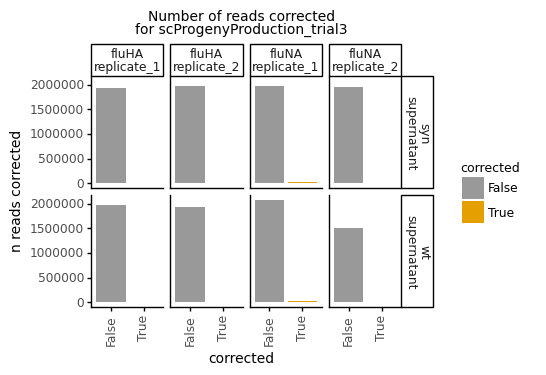

In [12]:
fig = (p9.ggplot(viral_bc_df, p9.aes(x='corrected',
                                     y='count_original_viral_bc',
                                     fill='corrected')) +
       p9.geom_bar(stat='identity') +
       p9.facet_grid('source+tag~gene+replicate') +
       p9.ggtitle('Number of reads corrected\n'
                  f'for {expt}') +
       p9.ylab('n reads corrected') +
       p9.theme(figure_size=(2*(viral_bc_df['gene'].nunique()),
                             3),
                axis_text_x=p9.element_text(angle=90),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))

# save plot
print(f"Saving plot to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)
print("Plot saved.")

# show plot
fig.draw()

Plot fraction of UMIs corrected **within each progeny sample**.

corrected,source,tag,gene,replicate,False,True,ratio
0,supernatant,syn,fluHA,replicate_1,1928141,14019,0.007218
1,supernatant,syn,fluHA,replicate_2,1978246,15678,0.007863
2,supernatant,syn,fluNA,replicate_1,1965563,17896,0.009023
3,supernatant,syn,fluNA,replicate_2,1943225,14712,0.007514
4,supernatant,wt,fluHA,replicate_1,1975068,12151,0.006115
5,supernatant,wt,fluHA,replicate_2,1928836,10719,0.005527
6,supernatant,wt,fluNA,replicate_1,2064226,19206,0.009218
7,supernatant,wt,fluNA,replicate_2,1504535,5664,0.003750


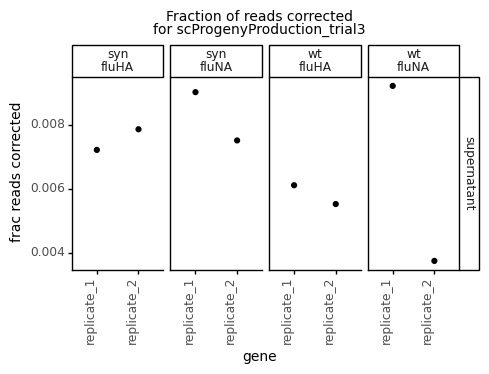

In [10]:
correction_ratios_df = (viral_bc_df
                        .groupby(['source',
                                  'tag',
                                  'gene',
                                  'replicate',
                                  'corrected'])
                        .agg(func=np.sum)
                        .reset_index()
                        .pivot_table(index=['source', 'tag', 'gene', 'replicate'],
                                     columns='corrected',
                                     values='count_original_viral_bc')
                        .reset_index()
                        .fillna(0))

correction_ratios_df['ratio'] = (correction_ratios_df[True] /
                                 (correction_ratios_df[True] +
                                  correction_ratios_df[False]))

display(correction_ratios_df)

fig = (p9.ggplot(correction_ratios_df, p9.aes(x='replicate', y='ratio')) +
       p9.geom_point() +
       p9.facet_grid('source~tag+gene') +
       p9.ggtitle('Fraction of reads corrected\n'
                  f'for {expt}') +
       p9.labs(x='gene',
               y='frac reads corrected') +
       p9.theme(figure_size=(5, 2.5),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center',
                axis_text_x=p9.element_text(angle = 90, hjust = 1))
       )

# show plot
fig.draw()

## Export corrected barcode frequencies

In [11]:
export_df = (viral_bc_df
             [['source',
               'tag',
               'gene',
               'replicate',
               'corrected_viral_bc',
               'count_corrected_viral_bc']]
             .reset_index(drop=True)
             .drop_duplicates()
             .rename(columns={'corrected_viral_bc': 'barcode',
                              'count_corrected_viral_bc': 'count'})
             )

# Write to csv
export_df.to_csv(viral_bc_in_progeny_corrected_csv,
                 index=False)